# Assess Latency
Measure the different sources of latency using a single- and multi-site implementation of Colmena

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import json
import sys

Configuration

In [2]:
funcx = Path('prod-runs/8KNL-20T4-funcx/')
parsl_redis = Path('prod-runs/8KNL-20T4-parsl/')

## Assess "Reaction Time" between Result Available and Processed
We look at the time between when a result completes on the worker, it is received by the task server, and processed by the thinker

In [3]:
def get_reaction_times(path: Path) -> pd.DataFrame:
    """Get the reaction times for a certain run
    
    Args:
        path: Path to the run
    Returns:
        Many different analyses for each type of tasks. These include
    """
    
    # Load in all of the tasks
    tasks = pd.read_csv(path / 'processed-results' / 'all-tasks.csv')
    tasks['run'] = path.name
    
    # Load compute the total proxy resolution time for inputs
    def _get_resolve_time(x):
        x = eval(x)
        return sum(i['resolve']['avg_time_ms'] * i['resolve']['calls'] for i in x.values() if 'resolve' in i) / 1000
    tasks['time_input_resolution'] = tasks['proxy_timing'].apply(_get_resolve_time)
    
    # Compute the time compute finished
    tasks['time_compute_done'] = tasks['time_compute_started'] + tasks['time_deserialize_inputs'] + tasks['time_async_resolve_proxies'] + tasks['time_running']
    
    # Compute the difference between the completion time and when it was received by the thinker
    tasks['latency_result_sending'] = tasks['time_result_received'] - tasks['time_compute_done']
    
    # Compute the time until the result was placed in the queue 
    tasks['latency_to_task_server'] = tasks['time_result_sent'] - tasks['time_compute_done']
    
    # How much of this time was communicating the result via FuncX/Parsl
    tasks['latency_workflow'] = tasks['latency_result_sending'] - tasks['time_serialize_results']
    
    # Get the set time
    def _get_resolve_time(x):
        x = eval(x)
        return sum(i['set']['avg_time_ms'] * i['set']['calls'] for i in x.values() if 'set' in i) / 1000
    tasks['time_write_result_proxy'] = tasks['proxy_timing'].apply(_get_resolve_time)
    
    # Get the time waiting for the result to show up
    def _get_resolve(x):
        x = eval(x)
        if 'proxy_stats' not in x:
            return 
        assert 'resolve' in x['proxy_stats'], list(x['proxy_stats'].keys())
        return x['proxy_stats']['resolve']['avg_time_ms'] / 1000
    tasks['latency_data'] = tasks['task_info'].apply(_get_resolve) + tasks['latency_result_sending']
    return tasks

In [4]:
with (funcx / 'duplicates.json').open() as fp:
    funcx_tasks = pd.concat([get_reaction_times(Path(x)) for x in json.load(fp)], ignore_index=True)

In [5]:
with (parsl_redis / 'duplicates.json').open() as fp:
    parsl_tasks = pd.concat([get_reaction_times(Path(x)) for x in json.load(fp)], ignore_index=True)

The time to serialize results for inference is dominated by the time to start the Globus transfer.

In [6]:
funcx_tasks.query('task_type=="inference"')['time_serialize_results'].describe()

count    4047.000000
mean        0.566594
std         0.167391
min         0.368768
25%         0.461849
50%         0.508460
75%         0.634598
max         3.858917
Name: time_serialize_results, dtype: float64

Compute the time between results completing and being received by the thinker. This measure conflates a few things: time to send notification and time the result is sitting in a processing backlog

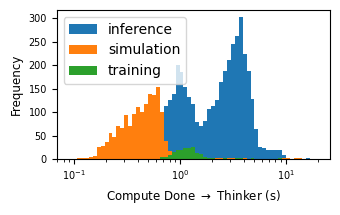

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.25), sharex=True)

min_ = np.log10(max(funcx_tasks['latency_to_task_server'].min(), 1e-2))
max_ = np.log10(funcx_tasks['latency_result_sending'].max())
bins = np.logspace(min_ - 0.1, max_ + 0.1, 64)

for task_type, group in funcx_tasks.groupby('task_type'):
    ax.hist(group['latency_result_sending'] , bins=bins, label=task_type)

ax.legend()
ax.set_xscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel('Compute Done $\\rightarrow$ Thinker (s)')

fig.tight_layout()

In [8]:
funcx_tasks.groupby('task_type')['latency_result_sending'].describe(percentiles=[0.25,0.50,0.75,0.95])

,count,mean,std,min,25%,50%,75%,95%,max
task_type,,,,,,,,,
inference,4047.0,2.583477,1.614234,0.473019,1.115094,2.473609,3.636255,5.052495,15.865678
simulation,1560.0,0.502203,0.697584,0.114574,0.314000,0.443065,0.579482,0.725274,13.581418
training,184.0,1.282353,0.752455,0.658738,0.974817,1.161751,1.357756,1.940083,8.713997


See the time between result completing and being acknolwedged by the task server, which removes any factor dealing with processing backlog on the thinker.

Text(0.5, 0, 'Compute Done $\\rightarrow$ Thinker (s)')

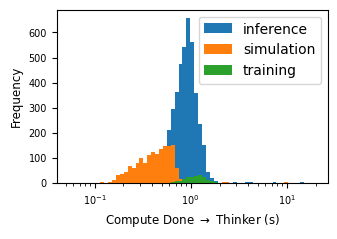

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.25), sharex=True)

min_ = np.log10(max(funcx_tasks['latency_workflow'].min(), 1e-2))
max_ = np.log10(funcx_tasks['latency_result_sending'].max())
bins = np.logspace(min_ - 0.1, max_ + 0.1, 64)

for task_type, group in funcx_tasks.groupby('task_type'):
    ax.hist(group['latency_to_task_server'] , bins=bins, label=task_type)

ax.legend()
ax.set_xscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel('Compute Done $\\rightarrow$ Thinker (s)')

In [10]:
funcx_tasks.groupby('task_type')['latency_to_task_server'].describe()

,count,mean,std,min,25%,50%,75%,max
task_type,,,,,,,,
inference,4047.0,0.948157,0.496198,0.457629,0.756265,0.909547,1.056877,14.913632
simulation,1560.0,0.493224,0.688608,0.113472,0.310357,0.435977,0.573288,13.507069
training,184.0,1.196725,0.668989,0.657353,0.952255,1.123380,1.310168,8.712902


See how much funcX has to do with it

See how long we're waiting for the data to transfer. Th

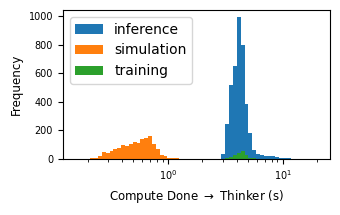

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.25), sharex=True)

min_ = np.log10(max(funcx_tasks['latency_data'].min(), 1e-2))
max_ = np.log10(funcx_tasks['latency_data'].max())
bins = np.logspace(min_ - 0.1, max_ + 0.1, 64)

for task_type, group in funcx_tasks.groupby('task_type'):
    ax.hist(group['latency_data'] , bins=bins, label=task_type)

ax.legend()
ax.set_xscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel('Compute Done $\\rightarrow$ Thinker (s)')


fig.tight_layout()
fig.savefig('figures/reaction-time-latency.png', dpi=320)
fig.savefig('figures/reaction-time-latency.pdf')

In [12]:
funcx_tasks.groupby('task_type')['latency_data'].describe()

,count,mean,std,min,25%,50%,75%,max
task_type,,,,,,,,
inference,4047.0,4.306861,0.929235,2.969514,3.788108,4.170855,4.544401,16.106122
simulation,1560.0,0.603182,0.695593,0.194536,0.410339,0.544037,0.681643,13.596283
training,184.0,4.416767,0.904820,3.287183,4.005207,4.370527,4.647041,12.582105


Compile the two into a single figure

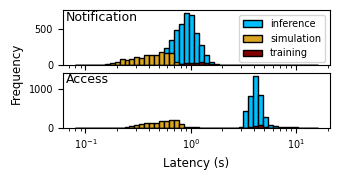

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 1.9), sharex=True, sharey=False)

# Get the bins for the histogram
min_ = -1
max_ = np.log10(funcx_tasks['latency_data'].max())
bins = np.logspace(min_ - 0.1, max_ + 0., 50)

# Plot the data
colors = {
    'inference': 'deepskyblue',
    'simulation': 'goldenrod',
    'training': 'maroon'
}
for task_type, group in funcx_tasks.groupby('task_type'):
    axs[0].hist(group['latency_to_task_server'], bins=bins, label=task_type,
                edgecolor='k', facecolor=colors[task_type])
    axs[1].hist(group['latency_data'], bins=bins, label=task_type,
                edgecolor='k', facecolor=colors[task_type])

# Label the axes
for ax in axs:
    ax.set_xscale('log')
axs[1].set_ylabel('Frequency', y=1.)
axs[1].set_xlabel('Latency (s)')

# Label the plots
axs[0].text(0.01, 0.99, 'Notification', ha='left', va='top', fontsize=9,
           transform=axs[0].transAxes)
axs[1].text(0.01, 0.99, 'Access', ha='left', va='top', fontsize=9,
           transform=axs[1].transAxes)

axs[0].legend(fontsize=7, ncol=1)

fig.tight_layout(h_pad=0.1)
fig.savefig('figures/latency-analysis_reaction-time.png', dpi=320)
fig.savefig('figures/latency-analysis_reaction-time.pdf')

We see latencies never above 10s for either of the types of latency.

Repeat the analysis with Parsl

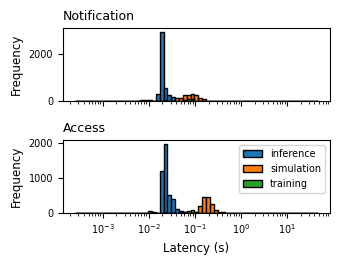

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.75), sharex=True, sharey=False)

# Get the bins for the histogram
min_ = -3.5
max_ = np.log10(parsl_tasks['latency_data'].max())
bins = np.logspace(min_ - 0.1, max_ + 0.1, 64)

# Plot the data
for task_type, group in parsl_tasks.groupby('task_type'):
    axs[0].hist(group['latency_to_task_server'], bins=bins, label=task_type, edgecolor='k')
    axs[1].hist(group['latency_data'], bins=bins, label=task_type, edgecolor='k')

# Label the axes
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('Frequency')
axs[1].set_xlabel('Latency (s)')

# Label the plots
axs[0].set_title('Notification', loc='left', fontsize=9)
axs[1].set_title('Access', loc='left', fontsize=9)

axs[1].legend(fontsize=7)

fig.tight_layout()
fig.savefig('figures/latency-analysis_reaction-time-parsl.png', dpi=320)
fig.savefig('figures/latency-analysis_reaction-time-parsl.pdf')

In [15]:
parsl_tasks.groupby('task_type')['latency_data'].describe()

,count,mean,std,min,25%,50%,75%,max
task_type,,,,,,,,
inference,4416.0,0.025428,0.015307,0.007211,0.020936,0.022406,0.026198,0.582300
simulation,1560.0,0.234154,1.066319,0.089315,0.157386,0.183515,0.217687,37.631699
training,192.0,0.092802,0.041799,0.054780,0.078323,0.089036,0.097908,0.564066


In [16]:
parsl_tasks.groupby('task_type')['latency_to_task_server'].describe()

,count,mean,std,min,25%,50%,75%,max
task_type,,,,,,,,
inference,4416.0,0.021204,0.008152,0.005659,0.018530,0.019640,0.021116,0.163149
simulation,1560.0,0.126834,1.063612,0.035621,0.062166,0.081394,0.106883,37.532212
training,192.0,0.080955,0.019113,0.043083,0.071063,0.079865,0.089484,0.242658


Parsl with Redis is _much_ better for the resolution times. Not that we should be too surprised.

## Measure Time to Decisions
We have a few steps where the Thinker must quickly decide the next task.

### Simulation Deployment
We are going to measure the time in the log file between when a simulation finishes and the next is received by the task server.latency_result_sending

In [17]:
def get_simulation_decision_times(path: Path, tz_offset: float = -18000) -> pd.DataFrame:
    """Compute the time between when a simulation is received
    and the next one sent off
    
    Args:
        path: Path to run directory
        tz_offset: In case logs and results are in different timezones (ugh)
    Returns:
        Dataframe with a 'to_task_server' and 'to_funcx' column
    """

    # Get the time a simulation was placed in the Redis queue
    receive_times = pd.read_json(path / 'simulation-results.json', lines=True)['time_result_sent'] - tz_offset
    
    # Get the times
    to_task = []
    to_funcx = []
    with open(path / 'runtime.log') as fp:
        for x in fp:
            if 'Client sent a run_simulation ' in x:
                to_task.append(datetime.strptime(x.split(" - ")[0], "%Y-%m-%d %H:%M:%S,%f").timestamp())
            elif 'Submitted run_simulation to run' in x:
                to_funcx.append(datetime.strptime(x.split(" - ")[0], "%Y-%m-%d %H:%M:%S,%f").timestamp())
    
    # Compute the reaction times
    to_task = np.array(to_task)
    to_funcx = np.array(to_funcx)
    decision_times = [
        np.min(to_task[to_task > x] - x) for x in receive_times[:len(to_task) // 10 * 8]
    ]
    funcx_times = [
        np.min(to_funcx[to_funcx > x] - x) for x in receive_times[:len(to_task) // 10 * 8]
    ]
    
    return pd.DataFrame({
        'to_decision': decision_times,
        'to_funcx': funcx_times
    })
funcx_sim_decision = get_simulation_decision_times(funcx)

In [18]:
funcx_sim_decision.describe([0.25, 0.50, 0.95])

,to_decision,to_funcx
count,416.000000,416.000000
mean,0.009748,0.009844
std,0.045530,0.044152
min,0.002222,0.003058
25%,0.004208,0.004630
50%,0.005236,0.005465
95%,0.009584,0.009525
max,0.681725,0.682725


### Training Response
How long between trained model and the first evaluate_mpnn submitted.

In [19]:
def get_training_decision_times(path: Path, n_tasks: int = 23, tz_offset: float = -18000) -> pd.DataFrame:
    """Compute the time between when a simulation is received
    and the next one sent off
    
    Args:
        path: Path to run directory
        n_tasks: Number of tasks per model
        tz_offset: In case logs and results are in different timezones (ugh)
    Returns:
    """
    
    # Get the time the result was placed in the redis queue
    receive_times = pd.read_json(path / 'training-results.json', lines=True)['time_result_sent'] - tz_offset # Revise to account for failed models!!!

    # Get the times
    done_times = []
    to_process = []
    to_task = []
    to_funcx = []
    with open(path / 'runtime.log') as fp:
        for x in fp:
            if 'left to go' in x: 
                to_process.append(datetime.strptime(x.split(" - ")[0], "%Y-%m-%d %H:%M:%S,%f").timestamp())
            elif 'Client sent a evaluate_mpnn ' in x:
                to_task.append(datetime.strptime(x.split(" - ")[0], "%Y-%m-%d %H:%M:%S,%f").timestamp())
            elif 'Submitted evaluate_mpnn to run on ' in x:
                to_funcx.append(datetime.strptime(x.split(" - ")[0], "%Y-%m-%d %H:%M:%S,%f").timestamp())
    
    # Compute the reaction times
    to_task = np.array(to_task)[::n_tasks]
    to_funcx = np.array(to_funcx)[::n_tasks]
    to_process = np.array(to_process)
    resolve_times = np.subtract(to_process, receive_times)
    decision_times = np.subtract(to_task, receive_times[:len(to_task)])
    funcx_times = np.subtract(to_funcx, receive_times[:len(to_task)])
    
    return pd.DataFrame({
        'to_resolve': resolve_times,
        'to_inference': decision_times,
        'to_funcx': funcx_times
    })
funcx_train_decision = get_training_decision_times(funcx)

In [20]:
funcx_train_decision.describe()

,to_resolve,to_inference,to_funcx
count,72.000000,64.000000,64.000000
mean,3.297818,3.873116,3.873944
std,0.475153,0.535892,0.535876
min,2.414549,2.903549,2.904549
25%,2.788139,3.352956,3.353206
50%,3.514593,4.054665,4.055165
75%,3.579294,4.199892,4.200892
max,4.166097,4.896093,4.898093


### Inference Decision
Measure the time between when we get the last inference result and finish processing it

In [21]:
def get_inference_decision_times(path: Path, n_tasks: int = 184, tz_offset: float = -18000) -> pd.DataFrame:
    """Compute the time between when a simulation is received
    and the next one sent off
    
    Args:
        path: Path to run directory
        n_tasks: Number of inference tasks per round
        tz_offset: In case logs and results are in different timezones (ugh)
    Returns:
        Dataframe with a 'to_task_server' and 'to_funcx' column
    """
    
    # Get the time it was placed in queue
    receive_times = pd.read_json(path / 'inference-results.json', lines=True)['time_result_sent'][n_tasks - 1::n_tasks] - tz_offset

    # Get the times
    process_times = []
    to_task = []
    with open(path / 'runtime.log') as fp:
        for x in fp:
            if 'Processed inference task 184/184' in x:
                process_times.append(datetime.strptime(x.split(" - ")[0], "%Y-%m-%d %H:%M:%S,%f").timestamp())
            elif 'Updated task list' in x:
                to_task.append(datetime.strptime(x.split(" - ")[0], "%Y-%m-%d %H:%M:%S,%f").timestamp())
    # Compute the reaction times
    to_task = np.array(to_task)
    decision_times = np.subtract(to_task, process_times)
    process_times = np.subtract(process_times, receive_times)
    
    return pd.DataFrame({
        'to_process': process_times,
        'to_update': decision_times,
        'total': process_times + decision_times
    })
with (funcx / 'duplicates.json').open() as fp:
    funcx_inf_decision = pd.concat([get_inference_decision_times(Path(x)) for x in json.load(fp)], ignore_index=True)

In [22]:
funcx_inf_decision.describe([0.25, 0.50, 0.95])

,to_process,to_update,total
count,21.000000,21.000000,21.000000
mean,3.249836,0.940762,4.190598
std,0.614677,0.082004,0.642474
min,2.362418,0.784000,3.267418
25%,2.666738,0.896000,3.541019
50%,3.368829,0.943000,4.369829
95%,4.142657,1.069000,5.046981
max,4.484603,1.114000,5.427603


## Dispatch Time
The final source of latency is the time it takes to dispatch compute onto a waiting worker

### Training Tasks
Determine the time it takes for FuncX workers to start the training process. We know the nodes are empty at this point, so this latency is form of underutilization.

In [23]:
def assess_training_startup(tasks: pd.DataFrame) -> pd.DataFrame:
    """Assess the latencies in starting up a model training
    
    Args:
        tasks: List of tasks to be assessed
    Returns:
        Associated latencies
    """
    
    train_tasks = tasks.query('task_type=="training"').copy()
    
    # Compute the time a process is blocking while waiting for a proxy to resolve
    def get_proxy_resolve_time(x):
        """Get """
        data = eval(x)
        return sum([
            i['resolve']['calls'] * i['resolve']['avg_time_ms'] / 1000 for i in data.values() if 'resolve' in i
        ])
    train_tasks['time_resolve'] = train_tasks['proxy_timing'].map(get_proxy_resolve_time)
    train_tasks['total_serialization'] = (train_tasks.time_deserialize_inputs + train_tasks.time_serialize_inputs 
                                          + train_tasks.time_async_resolve_proxies)
    train_tasks['funcx_communication'] = train_tasks['time_compute_started'] - train_tasks['time_input_received']
    train_tasks['total_latency'] = (train_tasks['time_compute_started']  - train_tasks['time_created'] + train_tasks['time_resolve'])
    
    return train_tasks[['total_serialization', 'time_resolve', 'funcx_communication', 'total_latency', 'time_running']]
funcx_train_startup = assess_training_startup(funcx_tasks)

In [24]:
funcx_train_startup.describe()

,total_serialization,time_resolve,funcx_communication,total_latency,time_running
count,184.000000,184.000000,184.000000,184.000000,184.000000
mean,0.515402,1.912869,0.555279,2.983458,344.032465
std,0.116303,0.953145,1.276965,1.260280,101.747825
min,0.380839,0.101569,0.071585,1.167847,130.559797
25%,0.455266,1.471418,0.097498,2.189520,259.457347
50%,0.493271,1.675332,0.106291,2.478706,363.120708
75%,0.542259,2.425796,0.174306,3.245373,428.003246
max,1.297368,6.719496,7.001238,8.716870,512.728535


### Inference Tasks
When the first model finishes training, there is under utilization between when the model finishes training and the results are sent

In [33]:
def assess_inference_initilization(tasks: pd.DataFrame, tasks_per_batch: int = 184) -> pd.DataFrame:
    """Assess the latencies in starting up a model training
    
    Args:
        tasks: List of tasks to be assessed
        tasks_per_batch: Number of tasks per inference batch
    Returns:
        Associated latencies
    """
    
    # Get the inference tasks
    inf_tasks = tasks.query('task_type=="inference"').copy()
    inf_tasks.sort_values('time_compute_started', inplace=True)
    
    # Assign them a batch ID
    inf_tasks['batch_id'] = None
    for gid, group in inf_tasks.groupby('run'):
        n_batches = len(group) // tasks_per_batch + 1
        batch_id = np.repeat(range(n_batches), tasks_per_batch)
        inf_tasks.loc[group.index, 'batch_id'] = batch_id[:len(group)]
    
    # Remove the first batch
    #inf_tasks.query('batch_id > 0', inplace=True)
    
    # Get the first one to start for each batch
    inf_tasks.sort_values('time_compute_started', inplace=True, ascending=True)
    inf_tasks['total_serialization'] = inf_tasks.time_deserialize_inputs + inf_tasks.time_serialize_inputs + inf_tasks.time_async_resolve_proxies
    inf_tasks['funcx_communication'] = inf_tasks['time_compute_started'] - inf_tasks['time_created']
    inf_tasks['total_startup'] = inf_tasks['funcx_communication'] + inf_tasks['time_input_resolution']
    
    # Remove all but the columns we want 
    inf_tasks = inf_tasks[['run', 'batch_id', 'total_serialization', 'funcx_communication', 'time_input_resolution',
                           'total_startup', 'time_running', 'proxy_timing']]
    
    # Get the first tasks
    first_tasks = inf_tasks.drop_duplicates(['run', 'batch_id'], keep='first')
    next_tasks = inf_tasks[np.logical_not(inf_tasks.index.map(lambda x: x in first_tasks.index).values)]
    
    return first_tasks, next_tasks
funcx_inf_startup, funcx_inf_second = assess_inference_initilization(funcx_tasks)

In [34]:
funcx_inf_startup.describe()

,total_serialization,funcx_communication,time_input_resolution,total_startup,time_running
count,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.000795,0.210212,12.866164,13.076376,53.508634
std,0.000214,0.187331,18.595874,18.596040,18.434079
min,0.000506,0.085256,2.612884,2.769571,41.475588
25%,0.000632,0.106449,3.327015,3.435190,43.934624
50%,0.000762,0.116707,3.570335,3.753606,45.043686
75%,0.000941,0.160437,8.911435,9.502626,47.318153
max,0.001253,0.771795,71.508763,71.653918,110.349401


In [35]:
funcx_inf_second.describe()

,total_serialization,funcx_communication,time_input_resolution,total_startup,time_running
count,4025.000000,4025.000000,4025.000000,4025.000000,4025.000000
mean,0.000608,105.493311,8.350122,113.843433,48.431641
std,0.000825,66.095237,14.665686,67.712633,15.005001
min,0.000311,0.075492,0.000071,2.525881,32.739631
25%,0.000475,49.608250,0.439066,60.896189,40.689827
50%,0.000534,105.047795,2.731984,113.470667,42.578479
75%,0.000595,153.016017,6.931078,161.685161,49.982922
max,0.018445,313.714484,200.774573,409.946511,229.748173


In [41]:
cache_hits = np.mean(funcx_inf_second['time_input_resolution'] < 0.1)
print(f'{cache_hits*100:.1f}% of tasks complete in under 100ms')

12.5% of tasks complete in under 100ms


The time to start an inference task is limited by the model arriving at the worker.

Text(0, 0.5, 'Startup Time')

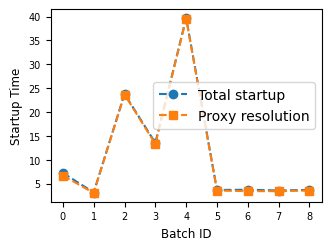

In [28]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

stats = funcx_inf_startup.groupby('batch_id')['total_startup'].describe()
ax.plot(stats.index, stats['mean'], '--o', label='Total startup')

stats = funcx_inf_startup.groupby('batch_id')['time_input_resolution'].describe()
ax.plot(stats.index, stats['mean'], '--s', label='Proxy resolution')


ax.legend()
ax.set_xlabel('Batch ID')
ax.set_ylabel('Startup Time')

We can see that the time to start the first batch is much larger, where we have to send both the model and search space

### Simulation Tasks
The time between when a simulation task is created and placed on the node

In [29]:
sim_tasks = funcx_tasks.query('task_type=="simulation"')

In [30]:
(sim_tasks.time_compute_started - sim_tasks.time_created).describe()

count    1560.000000
mean        6.239751
std        36.198796
min         0.070917
25%         0.096384
50%         0.106862
75%         0.151037
max       360.587921
dtype: float64

The median is only 330ms. There is a high maximum, but we are not getting charged for the job waiting in queue.